In [ ]:
# Matthew Alfredo
# matthewwalfredoo@gmail.com
# matthewalfredoo

In [ ]:
# classification two kinds of eye diseases.
# There will be only 4 classes where eyes are either Normal, Cataract, or Hypertension

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file here
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 70 Oct  3 12:37 kaggle.json


In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:25<00:00, 93.7MB/s]
100% 1.62G/1.62G [00:26<00:00, 66.7MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
import pandas as pd
df = pd.read_csv('full_df_4_classes.csv')
df.head() 

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
3,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg
4,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg


In [ ]:
df_cut = df.drop(df.columns[list(range(5, 16)) + list(range(3, 5)) + list(range(17, 18))], axis=1)
df_cut = df_cut.drop(columns=['ID'])
df_cut.head()

,Patient Age,Patient Sex,labels,filename
0,69,Female,['N'],0_right.jpg
1,57,Male,['N'],1_right.jpg
2,59,Male,['N'],8_right.jpg
3,70,Male,['N'],10_right.jpg
4,60,Female,['M'],13_right.jpg


In [ ]:
string_labels = []
for label in df_cut.labels:
  if(len(label) == 5):
    string_labels.append(label[2])
  else:
    print(label)

In [ ]:
df_cut = df_cut.drop(columns=['labels'])
df_cut = pd.concat([df_cut, pd.DataFrame(string_labels, columns = ['Labels'])], axis=1)

df_cut.head()

,Patient Age,Patient Sex,filename,Labels
0,69,Female,0_right.jpg,N
1,57,Male,1_right.jpg,N
2,59,Male,8_right.jpg,N
3,70,Male,10_right.jpg,N
4,60,Female,13_right.jpg,M


In [ ]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later
df_train = df_cut.sample(frac=0.8, random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_cut.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_cut), len(df_train), len(df_test))

3526 2821 705


In [ ]:
from keras_preprocessing.image.image_data_generator import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             shear_range=0.2,
                             fill_mode='nearest',
                             validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                              x_col='filename',
                                              y_col='Labels',
                                              class_mode='categorical',
                                              target_size=(224, 224),
                                              batch_size=8,
                                              subset='training',
                                              shuffle=True)

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                              x_col='filename',
                                              y_col='Labels',
                                              class_mode='categorical',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              subset='validation',
                                              shuffle=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                       directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                                       x_col='filename',
                                                       y_col='Labels',
                                                       class_mode='categorical',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       shuffle=True)

Found 2116 validated image filenames belonging to 4 classes.
Found 705 validated image filenames belonging to 4 classes.
Found 705 validated image filenames belonging to 4 classes.


In [ ]:
import tensorflow as tf
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_loss') < 0.4 and logs.get('val_accuracy') >= 0.85:
      print('The model has reached 90% accuracy and validation loss less than 40% and validation accuracy more than 85%')
      self.model.stop_training = True  # stopping the model training

callbacks = MyCallback()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('eye_disease_model.h5', monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq=354)

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                            patience=5, verbose=1)

In [ ]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1,
                                        restore_best_weights=True)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = tf.keras.models.Sequential([
    MobileNetV2(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3))),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

pre_trained_model.layers[0].trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 34,373,188
Trainable params: 32,115,204
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
pre_trained_model.compile(optimizer=tf.optimizers.Adam(),
                          loss=tf.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

In [ ]:
history2 = pre_trained_model.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=50,
                                callbacks=[
                                    # callbacks, 
                                    rlronp, estop],
                                verbose=1)

Epoch 1/50
265/265 [==============================] - 174s 610ms/step - loss: 6.1308 - accuracy: 0.8436 - val_loss: 1.1392 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 2/50
265/265 [==============================] - 159s 600ms/step - loss: 0.6534 - accuracy: 0.9022 - val_loss: 0.3676 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 3/50
265/265 [==============================] - 159s 602ms/step - loss: 0.3000 - accuracy: 0.9164 - val_loss: 0.2670 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 4/50
265/265 [==============================] - 158s 597ms/step - loss: 0.2685 - accuracy: 0.9244 - val_loss: 0.2921 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 5/50
265/265 [==============================] - 158s 597ms/step - loss: 0.2385 - accuracy: 0.9286 - val_loss: 0.2345 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 6/50
265/265 [==============================] - 158s 597ms/step - loss: 0.2295 - accuracy: 0.9329 - val_loss: 0.2848 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 7/50
265/265 [==========================

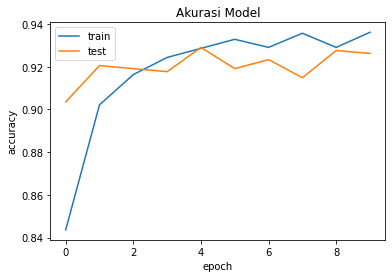

In [ ]:
import matplotlib.pyplot as plt

# plotting accuracy along the epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

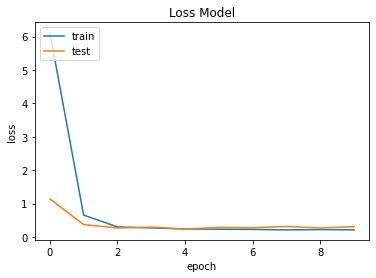

In [ ]:
# plotting loss along the epochs
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
import pathlib

# saving the model in SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(pre_trained_model, export_dir)
 
# Convert SavedModel to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model_eye_disease.tflite')
tflite_model_file.write_bytes(tflite_model)

137330716

In [ ]:
# Menyimpan model akhir

pre_trained_model.save("model_eye_disease.h5")
tf.keras.models.save_model(pre_trained_model,'model_eye_disease.hdf5')